# Where does one's time go in a day?

In this notebook, I will visualize a specified range of days using a **modified** stacked bar chart with data from `RescueTime` (supported) and `Fitbit` (not yet supported).

Viusalizing my data using a stacked 24-hour plot, helps me quickly identify where my time is going and which activities I am spending time on. The anomolies in this chart are just as interesting as the patterns that arrise. 

For more questions, please feel free to reach out to @paula on OpenHumans.org.

## Steps
1. Define your inputs 
    - This is the only step that YOU need to make slight modifications to!!


2. Get the data


3. Reformat the data
    - Trasform it to be on the minute and add tags for every minute of the day (don't worry this is all automatic). To see a more helpful guide for understanding the API's, I recommend the `rescue-vs-step-counts` notebook.
    

4. Visualize - Stacked Bar Chart

---

## Step 1: Enter Inputs 

#### Date Range

Either enter number of days from today or enter a date range

In [2]:
USING_DAYS_FROM_TODAY = False 

# If True: modify the number below
DAYS_FROM_TODAY = 14

# If False: modify the date range below
START_DATE = '2020-05-11'
END_DATE ='2020-05-26'

#### Data Sources

Note: Currently this notebook only supports RescueTime

In [3]:
USING_RESCUETIME = True
USING_FITBIT = False

#### Level of Detail

Select granularity of data

RescueTime Options: `activity`, `category`, `productivity` (Example values: youtube.com, Video, -2)

In [4]:
RESC_DETAIL = 'category'

#### Colors

Specify colors for known tag names, all remaining unspecified tags will be assigned a random color.

In [5]:
MY_COLORS = {'asleep': '#783f04ff',
             'device': '#70a1f5', 
             'active': '#f1c232ff', 
             'restless': '#ffccf2',
             'awake': '#7fffd4',
             'no entry': '#ffffff',
             'other': '#e8e8e8'}

#### *Optional*: Reduce Tag List

Highlight only specific tag(s), otherwise all available categories will have a unique color. Adding tag names here will result in only those tags being highlighted in the final chart.

In [6]:
# If this list is left empty, all categories will be shown and have a unique color
HIGHLIGHT_ONLY_CATEGORY_LIST = []

---

## Step 2: Get the Data

**Load modules and set up api**

In [7]:
import json
import os
import requests
from ohapi import api

from datetime import date, datetime, timedelta as td
import matplotlib.dates as mdates
import arrow

import numpy as np
import pandas as pd
import random

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

**Chart Size**

In [8]:
fsize = 22
params = {
    'axes.labelsize': fsize, 
    'axes.titlesize':fsize, 
    'axes.titlepad': 20,
    'xtick.labelsize':fsize,
    'xtick.major.pad': 5, 
    'ytick.labelsize':fsize,
    'axes.labelpad': 20,
    'lines.linewidth' : 3,
    'figure.titlesize': fsize,
    'figure.figsize' : (16,8),
    'legend.title_fontsize': fsize,
    'legend.fontsize': fsize #*0.925, 
} 
plt.rcParams.update(params) 
plt.close('all')

**Date Range**

In [9]:
if USING_DAYS_FROM_TODAY == True:
    START_DATE = (datetime.now() - pd.DateOffset(days=DAYS_FROM_TODAY)).strftime("%Y-%m-%d")
    END_DATE =  (datetime.now() + pd.DateOffset(days=1)).strftime("%Y-%m-%d")

# If number of days is False, then the user defined date range will be used
print(f'Data from {START_DATE} through {END_DATE}, not including the latest date.')

Data from 2020-05-11 through 2020-05-26, not including the latest date.


**Colors**

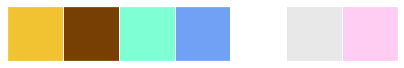

In [27]:
# Display colors 
my_color_schema = MY_COLORS
my_color_palette = [value for (key, value) in sorted(my_color_schema.items())]
my_color_categories = [key for (key, value) in sorted(my_color_schema.items())]
sns.palplot(my_color_palette)

**Open Humans Api**

In [11]:
user = api.exchange_oauth2_member(os.environ.get('OH_ACCESS_TOKEN'))

### Data Source: RescueTime

In [12]:
fileurl = ''
for entry in user['data']:
    if entry['source'] == "direct-sharing-149":
        fileurl = entry['download_url']
        break

rescuetime_data = requests.get(fileurl).json()



date = []
time_spent_seconds = []
activity = []
category = []
productivity = []
for element in rescuetime_data['rows']:
    date.append(element[0])
    time_spent_seconds.append(element[1])
    activity.append(element[3])
    category.append(element[4])
    productivity.append(element[5])
date = [datetime.strptime(dt,"%Y-%m-%dT%H:%M:%S") for dt in date]

In [13]:
rt_df = pd.DataFrame(data={
    'time_spent_seconds': date,
    'Seconds': time_spent_seconds,
    'activity': activity,
    'category': category,
    'productivity': productivity
})

In [14]:
# Remove the time but retain the date type
rt_df['Date'] = pd.to_datetime(rt_df['time_spent_seconds'].dt.date)

# We don't need all the data, use the date range specified 
rt_df = rt_df[(rt_df['Date'] >= START_DATE) & (rt_df['Date'] <= END_DATE)].copy()

# Data is recorded every 5 minutes, but there is a timer second so we can re-create a more accurrate start/end date
rt_df['Seconds Sum Per 5Min'] = rt_df.groupby(['time_spent_seconds'])['Seconds'].apply(lambda x: x.cumsum())

rt_df['Date End'] = rt_df['time_spent_seconds'] + pd.to_timedelta(rt_df['Seconds Sum Per 5Min'], unit='s')
rt_df['Date Start'] = rt_df['Date End'] - pd.to_timedelta(rt_df['Seconds'], unit='s')

### WIP Data Source: Fitbit

Need intra level data

In [15]:
# fileurl = ''
# for entry in user['data']:
#     if entry['source'] == "direct-sharing-102":
#         fileurl = entry['download_url']
#         break

# fitbit_data = requests.get(fileurl).json()

# date = []
# steps = []

# for year in fitbit_data['tracker-steps'].keys():
#     for entry in fitbit_data['tracker-steps'][year]['activities-tracker-steps']:
#         date.append(entry['dateTime'])
#         steps.append(entry['value'])
        
# fitbit_steps = pd.DataFrame(data={
#                 'date':date,
#                 'steps': steps})
# fitbit_steps['date'] = pd.to_datetime(fitbit_steps['date'])
# fitbit_steps = fitbit_steps.set_index('date')

---

## Step 3: Reshape the Data

In [16]:
def time_dataframe_prep(df, start_date, end_date, start_date_column, end_date_column, category_column):
    """    
    Returns an exploded dataframe, with every minute labeled with the event name or 'no entry'.
    
    Parameters
    ----------
        df : dataframe
            A dataframe that contains tagged timstamps
        start_date : str
            Date of first entry 
        end_date :str 
            Date of last entry
        start_date_column : datetime
            Column that contains when the event started
        end_date_column : datetime 
            Column that contains when the event ended
        category_column : str
            Column that contains the event tag name

    
    Returns
    -------
        df_minutes_se : dataframe
            Table with every minute tagged
    
    
    """
    ########################    
    ## Step 1: Create a dataframe of just the end dates
    ########################
    df_end = df[[end_date_column]].copy()
    # Add a column for 'no entry'
    df_end[category_column] = 'no entry'

    # If there is no gap in data (as in there is an entry immediately following the previous),
    # remove the record from the df_end dataframe
    start_date_pt_list = list(df[start_date_column].unique())
    df_end = df_end[~df_end[end_date_column].isin(start_date_pt_list)]

    ########################
    ## Step 2: Combine End and Start Dates into single dataframe
    ########################
    # Create a two column data frame with the start date and the category
    df_start = df[[start_date_column, category_column]].copy()

    # Update column names to match that of df_start
    df_end.rename(columns = {end_date_column: start_date_column}, inplace = True)
    # Append the df_end dataframe to the bottom
    df_entries = pd.concat([df_start, df_end])

    ########################
    ## Step 3: Expand Dataset - Every Second
    ########################
    # Create a dataframe of second intevals between two dates   
    time_range = pd.date_range(start_date, end_date, freq= '1s')
    time_range_df = pd.DataFrame(time_range).rename(columns = {0: 'date_time'})
    # Convert to time
    time_range_df['date_time'] = pd.to_datetime(time_range_df['date_time'])
    
    ########################
    ## Step 4: Add our time stamps to the expanded time dataframe
    ########################
    df_seconds = pd.merge(time_range_df, df_entries, how = 'left',  
                      left_on = 'date_time', right_on = start_date_column)
    # Find the first date_time with a category entry
    date_of_first_entry = df_seconds[(df_seconds[category_column] != 'no entry')  
                                     & (~df_seconds[category_column].isna())  
                                    ]['date_time'].min()
    # Find the index of the first entry
    index_of_first_entry = df_seconds.index[df_seconds['date_time'] == date_of_first_entry][0]
    # Reduce the dataframe to begin with the first entry
    df_seconds2 = df_seconds[index_of_first_entry:].copy()
    
    ########################
    ## Step 5: Label every minute
    ########################
    # Forward fill the category until next entry
    df_seconds2[category_column] = df_seconds2[category_column].ffill()
    df_seconds2[start_date_column] = df_seconds2[start_date_column].ffill()

    ########################
    ## Step 6: Pick the end of a minute entry (at 58 seconds)
    ########################
    # Expand the time stamp into the relevant time components
    
    # df_seconds2[['hour','minute','second']] = pd.to_timedelta(
    #     df_seconds2['date_time']).dt.components.iloc[:, 1:4]
    df_seconds2['hour'] = df_seconds2['date_time'].dt.hour
    df_seconds2['minute'] = df_seconds2['date_time'].dt.minute
    df_seconds2['second'] = df_seconds2['date_time'].dt.second

    # Select the entries at specified second interval (otherwise the frequency is too much for the chart)
    df_minutes = df_seconds2[df_seconds2['second'] == 58].reset_index()
    df_minutes['date_time_min'] = df_minutes['date_time'].values.astype('<M8[m]')

    ########################
    ## Step 7: Add duration columns
    ########################
    df_minutes['duration_minutes'] = 1

    # Find the index of the latest entry
    latest_date = df_minutes[df_minutes[category_column] != 'no entry']['date_time'].max()
    index_of_last_entry = df_minutes.index[df_minutes['date_time'] == latest_date][0]

    # Reduce the dataframe to begin with the first entry
    df_minutes_se = df_minutes[0:index_of_last_entry].copy()

    return df_minutes_se

In [17]:
CATEGORY_COL_NAME_1 = RESC_DETAIL

# Expand our rescuetime data as that is bulk of my data
res_time_data = time_dataframe_prep(df = rt_df, 
                                         start_date = START_DATE,
                                         end_date = END_DATE, 
                                         start_date_column = 'Date Start', 
                                         end_date_column = 'Date End', 
                                         category_column = CATEGORY_COL_NAME_1)

res_time_data.sort_values('date_time_min', ascending = True).head(5)


,index,date_time,Date Start,category,hour,minute,second,date_time_min,duration_minutes
0,58,2020-05-11 00:00:58,2020-05-11 00:00:00,Photos,0,0,58,2020-05-11 00:00:00,1
1,118,2020-05-11 00:01:58,2020-05-11 00:00:00,Photos,0,1,58,2020-05-11 00:01:00,1
2,178,2020-05-11 00:02:58,2020-05-11 00:00:00,Photos,0,2,58,2020-05-11 00:02:00,1
3,238,2020-05-11 00:03:58,2020-05-11 00:00:00,Photos,0,3,58,2020-05-11 00:03:00,1
4,298,2020-05-11 00:04:58,2020-05-11 00:04:26,no entry,0,4,58,2020-05-11 00:04:00,1


## Step 4: Visualize Data

In [18]:
def create_chart_xy_components(d, date_time_column, start_date, end_date, category_column):
    """    
    Returns a dataframe with columns specifically for visualizing the stack bar plot.
    
    Parameters
    ----------
    d : dataframe
        Exploded dataframe
    date_time_column : datetime
        A column that contains a timestamp
    start_date : str
        Date of first entry 
    end_date :str 
        Date of last entry
    category_column : str
        Column that contains the event tag name
    
    Returns
    -------
    d : dataframe
        A dataframe with additional columns for plotting
    
    """
    # Reduce the dataframe to the specified date range
    d = d[(d[date_time_column] >= start_date) & (d[date_time_column] <= end_date)].copy()

    # Remove time stamps (x-axis)
    d['Date Abr'] = d['date_time'].dt.date
    
    # Add day of week
    d['date_week'] = d['date_time'].dt.strftime('%Y-%m-%d, %a')

    # A float conversion of time (y-axis scaled for 24 hour period)
    d['time_from_day_start'] = (d[date_time_column] - d[date_time_column].dt.normalize()).dt.total_seconds().fillna(0)/(60*60)
    
    return d

In [19]:
def organize_categories_colors(d, category_column, my_color_categories, specified_category_list = []):
    """    
    Returns a two lists and a dictionary of color hashes, ordered tag names and the pairs.
    
    Parameters
    ----------
    d : dataframe
        Exploded dataframe with additional columns for plotting
    category_column : str
        Column that contains the event tag name
    my_color_categories : str list
        List of colors for a list of specified tags
    specified_category_list : str list
        Optional list of event tag names with unique colors, while the rest are all uniform and grey
    
    Returns
    -------
    color_palette : list
        A list of color hashes
    category_list_names_ordered : list
        A list of event tag names that is ordered for legend display to match the color order.
    color_pairs_main : dictionary
        A combination of the tags and matching color hashes.
    
    """

    ### Colors & Categories
    category_list = list(d[category_column].unique())
    
    ## Which categories have not yet been assigned a color in the my_color_schema
    unknown_category_list = list(set(category_list) - set(my_color_categories))

    # Generate color palette for the tags that weren't specified previously 
    r = lambda: random.randint(0,255)
    long_color_list = []
    for i in range(0, len(unknown_category_list)):
        long_color_list.append('#%02X%02X%02X' % (r(),r(),r()))
    color_list = long_color_list

        
    # Zip colors
    color_pairs_new = dict(zip(unknown_category_list, color_list))

    # Add the category/color pairs already defined in my_color_schema dictionary
    known_category_list = list(set(category_list) & set(my_color_categories))
    modified_my_color_schema = {x: my_color_schema[x] for x in known_category_list}


    # Combine new 
    color_pairs = {**color_pairs_new, **modified_my_color_schema}


    # Focus only a subset of categories
    if specified_category_list != []:
        # Create a list where all but the specified entries are included
        category_list_remaining = category_list.copy()
        [category_list_remaining.remove(x) for x in specified_category_list]
        # Convert all the not specified entries to the same color (make it easier to visually inspect for patterns)
        color_pairs.update(dict.fromkeys(category_list_remaining, '#e8e8e8'))

    # Ordered categories and colors
    category_list_names_ordered = [key for (key, value) in sorted(color_pairs.items())]
    color_palette = [value for (key, value) in sorted(color_pairs.items())]
    
    return color_palette, category_list_names_ordered, color_pairs

In [31]:
def daily_chart_24_hours(d, category_column, category_list_names_ordered, color_palette, 
    add_reference_lines = False, top_line = 9, bottom_line = 17, 
    legend_on = False, turn_xaxis_on = True):

    """    
    Returns a multi-day 24-hour stacked bar plot.
    
    Parameters
    ----------
    d : dataframe
        Exploded dataframe with additional columns for plotting
    category_column : str
        Column that contains the event tag name
    category_list_names_ordered : list
        Ordered string tags that match the color palette order
    color_palette : list
        List of color hashes that correspond to the tags
        
    Optional Parameters
    ----------
    add_reference_lines : boolean
        Display two horizonatal lines to draw your eye to particular times
    top_line : int
        Military time value for 1st horizontal line
    bottom_line : int
        Military time value for 2nd horizontal line
    legend_on : boolean
        Display legend 
    turn_xaxis_on : boolean
        Display xaxis date values

    """   
    
    plt.style.use('fivethirtyeight')

    v_val= 0
    h_val= 200
    verts = list(zip([-h_val,h_val,h_val,-h_val],[-v_val,-v_val,v_val,v_val]))

    fig, ax = plt.subplots()

    for i in range(len(category_list_names_ordered)):
        plt.scatter(d[d[category_column] == category_list_names_ordered[i]]['Date Abr'], 
                    d[d[category_column] == category_list_names_ordered[i]]['time_from_day_start'], 
                    s = 2000,
                    c = color_palette[i],
                    marker = (verts)
                )
    plt.yticks(np.arange(0, 25, step=6)) 

    xstart = d['Date Abr'].min() - pd.DateOffset(days=1)
    xend = d['Date Abr'].max() + pd.DateOffset(days=1)
    plt.xlim(xstart, xend)

    # Add labels with Day of the week at the end, ordered
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %-d, %a'))

    # Remove the extra date at the front and end
    locs, labels = plt.xticks() 
    date_label_list = list(d['date_time'].dt.strftime('%b %-d, %a').unique())
    plt.xticks(np.arange(locs[0], locs[0] + len(date_label_list) + 1, step =1), 
        [""] + date_label_list + [""], 
        rotation=90)

    if turn_xaxis_on == False:
        ax.tick_params(labelbottom=False)    


    if legend_on == True:
        leg = plt.legend(category_list_names_ordered, bbox_to_anchor=(1.15,0.5), 
                   loc="center", title = (r"$\bf{" + category_column + "}$"), fancybox=True)

        for i in leg.legendHandles:
            i.set_linewidth(5)
    else:
        plt.legend('')

    plt.ylabel('Time of Day')
    plt.gca().invert_yaxis()
    plt.xlabel('Date')
    plt.title(r"$\bf{" + 'Recorded' + "}$" + ' ' + r"$\bf{" + 'Daily' + "}$" + ' ' + r"$\bf{" + 'Minutes' + "}$" +
        f"\nDate Range: {str(xstart.strftime('%Y-%m-%d'))} to {str(xend.strftime('%Y-%m-%d'))}")


    # Reference Lines
    if add_reference_lines == True:
        plt.axhline(y=top_line, linewidth=2, color='black', linestyle = '--')
        top_line_text = '  Start: {}'.format(top_line)
        plt.text(x=xend, y=top_line, s=top_line_text, alpha=0.7, color='#334f8d')

        bottom_line_text = '  End: {}'.format(bottom_line)
        plt.axhline(y=bottom_line, linewidth=2, color='black', linestyle = '--')
        plt.text(x=xend, y=bottom_line, s=bottom_line_text, alpha=0.7, color='#334f8d')

    plt.show()

In [32]:
# What level of granularity are the tags we will be displaying?
breakdown_level_col = RESC_DETAIL

data = create_chart_xy_components(d = res_time_data, 
                                  date_time_column = 'date_time', 
                                  start_date = START_DATE, 
                                  end_date = END_DATE, 
                                  category_column = breakdown_level_col)

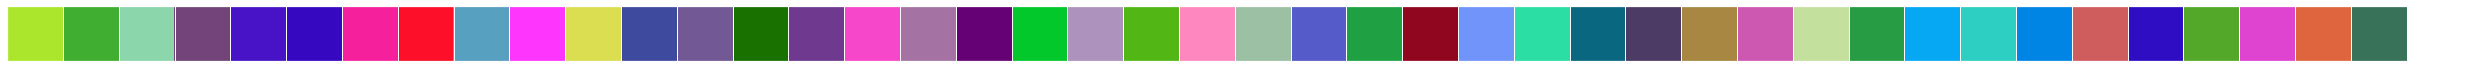

In [33]:
# Color and Category Selection
(color_palette, 
 category_list_names_ordered, 
 color_pairs_main) = organize_categories_colors(d = data,
                                                category_column = breakdown_level_col, 
                                                my_color_categories = my_color_categories,
                                                specified_category_list = HIGHLIGHT_ONLY_CATEGORY_LIST
                                               )
# Output color palette
sns.palplot(color_palette)

In [34]:
# Color table
# pd.DataFrame(color_pairs_main.items(), columns = ['category', 'color']).sort_values('category')

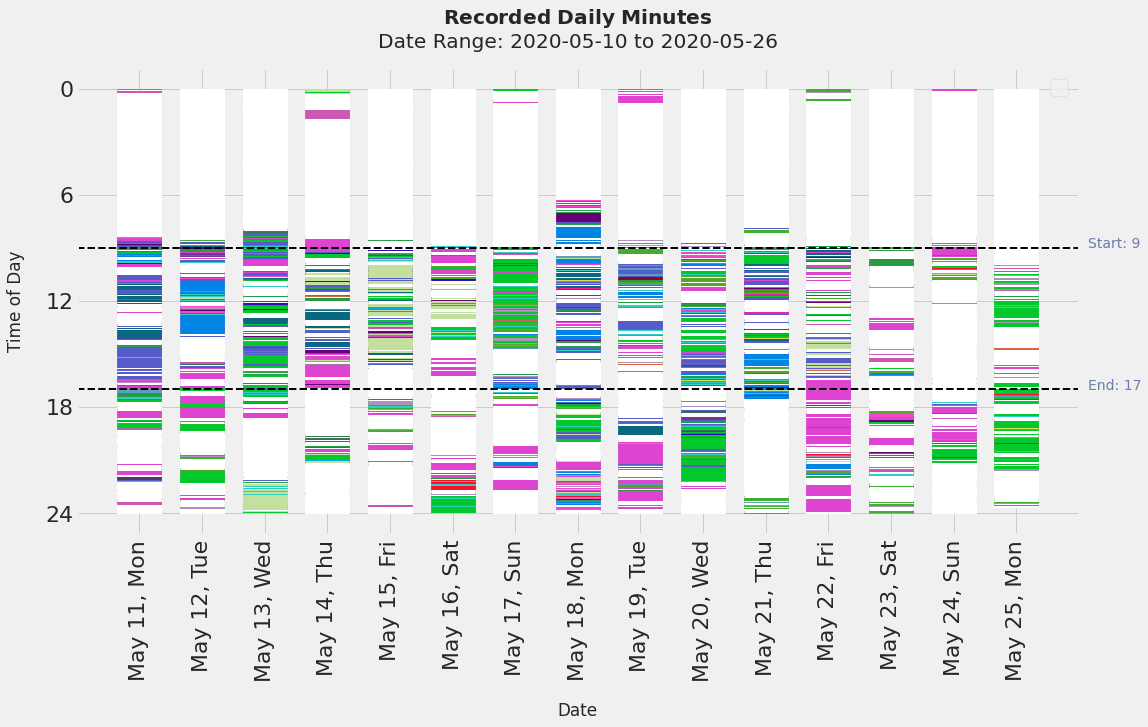

In [35]:
daily_chart_24_hours(d = data, 
                     category_column = breakdown_level_col,
                     category_list_names_ordered = category_list_names_ordered,
                     color_palette = color_palette,
                     add_reference_lines = True,
                     top_line = 9, 
                     bottom_line = 17,
                     legend_on = False,
                     turn_xaxis_on = True
                    )